# nema3 PDE=0.3, sigmaT = 50 ps, LXe = 20 mm all 

- Phantom : nema 3
- Events: all
- Detector geometry: SiPMs in LXe, with Hamamatsu sipms
- Time resolution: 50 ps
- qcut > 5 pes
- ntof > 7
- PDE = 0.3
- LXe = 20 mm

In [1]:
using Pkg
Pkg.activate(normpath(joinpath(@__DIR__, "..")))  #activate environment in ,,/src

In [2]:
using Plots
using DataFrames
using HDF5
using PhysicalConstants
using PhysicalConstants.CODATA2018
using Unitful

In [3]:
using Glob
using CSV

In [4]:
using Statistics
using StatsBase
using Printf

In [5]:
using Logging

In [6]:
using ATools

In [7]:
include("../src/ANema.jl") 

Main.ANema

In [8]:
println(names(ATools))

[:ATools, :centers, :dxyz, :edges, :find_max_xy, :fit, :fit_gauss, :fit_gauss_fm, :fit_pol1, :fit_pol2, :fit_pol3, :fit_profile, :fitg1, :fitg2, :fphi, :hist1d, :hist2d, :in_range, :mean_std, :p1df, :phixy, :rxy, :select_by_column_value, :select_by_column_value_closed_interval, :select_by_column_value_closed_left_interval, :select_by_column_value_closed_right_interval, :select_by_column_value_ge, :select_by_column_value_gt, :select_by_column_value_interval, :select_by_column_value_le, :select_by_column_value_lt, :select_by_index, :select_event, :wstd]


In [9]:
println(names(ANema))

[:ANema, :cdoi, :crt, :ctsr, :deltatime, :dftolor, :radial_correcction, :readdf, :selectinterval, :setunits, :write_lors_hdf5, :writemdf]


In [10]:
import Unitful:
    nm, μm, mm, cm, ns, μs, ms, ps, s

In [11]:
function loglevel(log)
    if log == "Debug"
        logger = SimpleLogger(stdout, Logging.Debug)
    elseif log =="Info"
        logger = SimpleLogger(stdout, Logging.Info)
    else
        logger = SimpleLogger(stdout, Logging.Warn)
    end
    old_logger = global_logger(logger)
end

loglevel (generic function with 1 method)

## NB functions
- These are specific for plotting and are better kept in the NB

In [12]:
loglevel("Warn")

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(44) open, 0 bytes waiting))), Info, Dict{Any, Int64}())

# Notebook

In [12]:
dir = "../data/"
dirp = "../plots"
conf = "n3-w-20mm-all"
out = "n3mf-w-20mm-phot"
path = joinpath(dir, conf)
pathp = joinpath(dirp, conf)
patho = joinpath(dir, out)

if isdir(pathp) == false
    mkdir(pathp)
end

if isdir(patho) == false
    mkdir(patho)
end
println("input dir ", path)
println("plots in ", pathp)
println("merged DF in ", patho)

input dir ../data/n3-w-20mm-all
plots in ../plots/n3-w-20mm-all
merged DF in ../data/n3mf-w-20mm-phot


In [13]:

ndf = ANema.readdf(path) 
println("data frame has length of ", nrow(ndf))
println("data frame names ", names(ndf))

data frame has length of 1949774
data frame names ["nsipm1", "nsipm2", "phistd1", "phistd2", "q1", "q2", "r1", "r2", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zstd1", "zstd2", "zt1", "zt2"]


## q1 vs q2

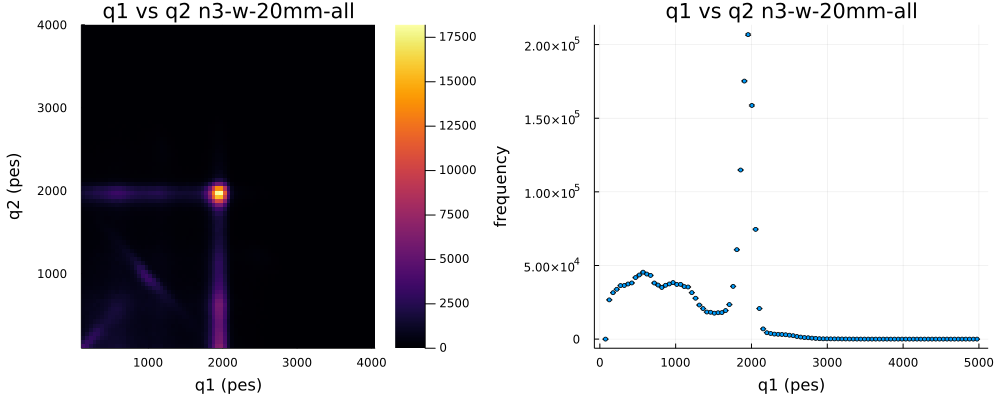

In [14]:
ANema.ANema.q1vsq2(ndf, tit="q1 vs q2 $conf", filename=joinpath(pathp, "q1q2"), save=true)

## Cut in (q1,q2) 

In [15]:
ndfq =ANema.selectinterval(ndf, "q1", "q2", 1700.0, 2100.0);
println("after q1q2 cut: ndfq has a length of ", nrow(ndfq))

after q1q2 cut: ndfq has a length of 321299


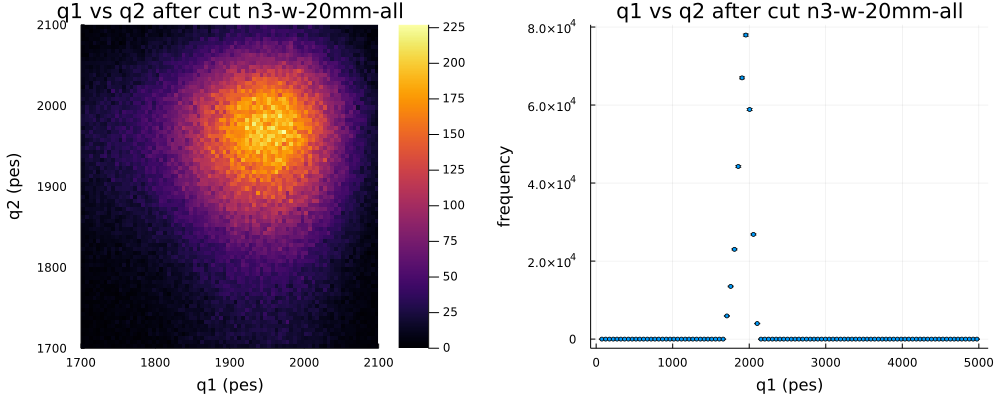

In [16]:
ANema.q1vsq2(ndfq, tit="q1 vs q2 after cut $conf", 
filename=joinpath(pathp, "q1q2-qcut"), save=true)

## r vs q

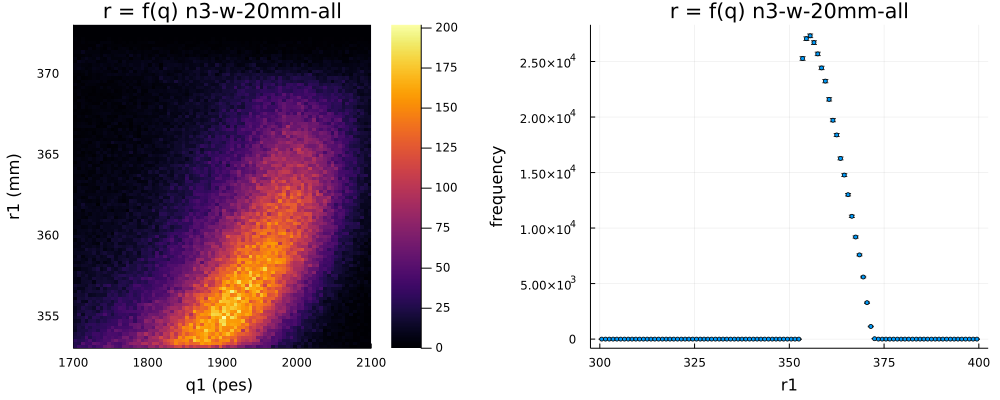

In [17]:
ANema.r1q1(ndfq,tit="r = f(q) $conf", filename=joinpath(pathp, "rq"), save=true)

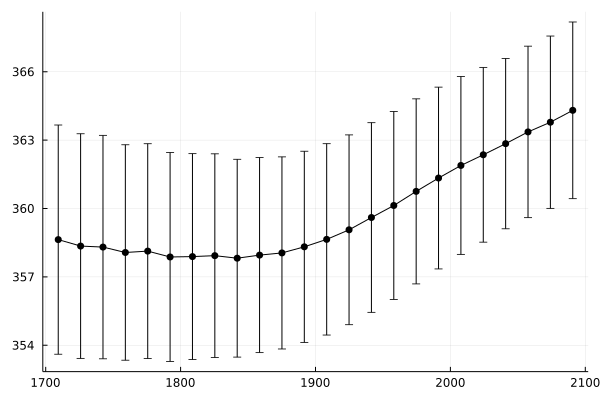

In [18]:
dfp, p1 = p1df(ndfq.q1, ndfq.r1, 25)
plot(p1)

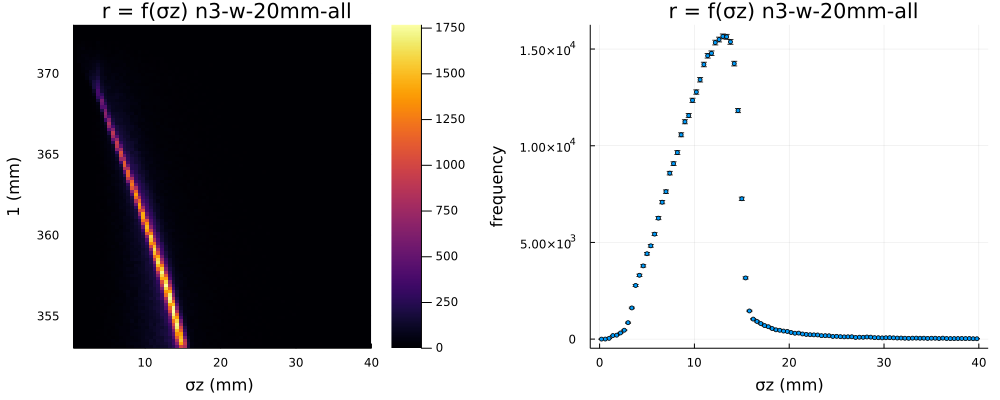

In [19]:
ANema.zstd(ndfq, tit=" r = f(σz) $conf", filename=joinpath(pathp, "zstd"), save=true)

In [20]:
ndfz =ANema.selectinterval(ndfq, "zstd1", "zstd2", 1.0, 16.0);
println("after zstd cut: ndfz has a length of ", nrow(ndfz))

after zstd cut: ndfz has a length of 297053


Fit parameters: a = 372.71 b = -1.32 c =  0.01 Fit errors: a =   0.5 b =  0.13 c = 0.0074

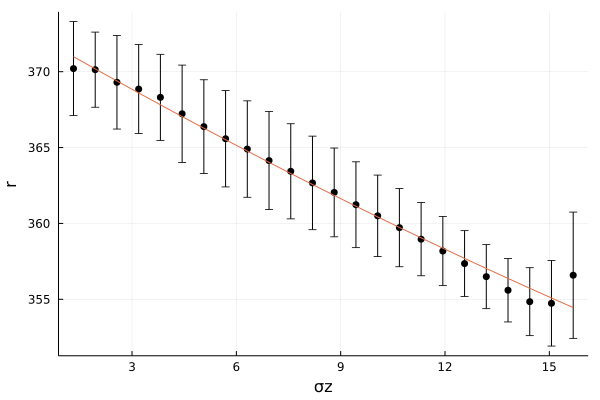

In [22]:
fz2, pz2 = fit_profile(ndfz.zstd1, ndfz.r1, "σz", "r", "pol2")
fpars = fz2.fitpar
fstds = fz2.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f c = %5.2g " fpars[1] fpars[2] fpars[3]
@printf "Fit errors: a = %5.1g b = %5.2g c = %5.2g" fstds[1] fstds[2] fstds[3]
ANema.pout(pz2, joinpath(pathp, "zstd-fitpol2"))
plot(pz2)

Fit parameters: a = 372.71 b = -1.32 c =  0.01 Fit errors: a =   0.5 b =  0.13 c = 0.0074

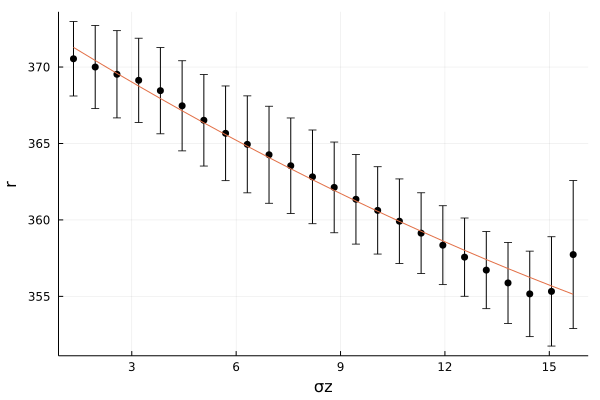

In [23]:
fzr2, pzr2 = fit_profile(ndfz.zstd2, ndfz.r2, "σz", "r", "pol2")
fpars = fz2.fitpar
fstds = fz2.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f c = %5.2g " fpars[1] fpars[2] fpars[3]
@printf "Fit errors: a = %5.1g b = %5.2g c = %5.2g" fstds[1] fstds[2] fstds[3]
ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pzr2)

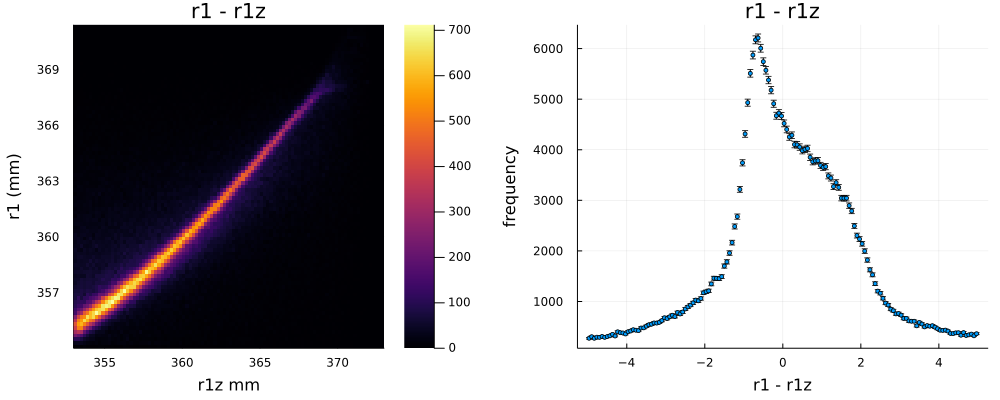

In [24]:
r1z = fz2.g.(ndfz.zstd1) + 0.0 * ones(length(ndfz.q1)) ; 
ANema.plotreso(r1z, ndfz.r1, "r1z mm", "r1 (mm)", -5., 5.0, tit="r1 - r1z", 
         filename=filename=joinpath(pathp, "r1-r1z"), save=true)


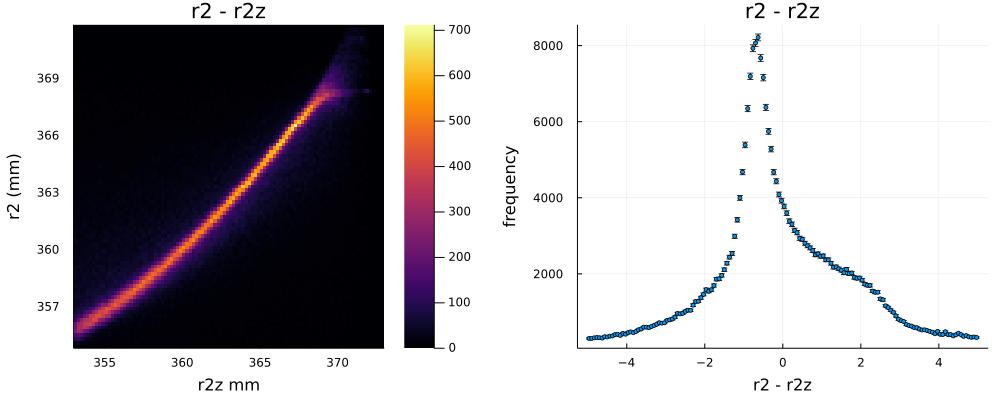

In [25]:
r2z = fzr2.g.(ndfz.zstd2) + 0.0 * ones(length(ndfz.q2)) 
ANema.plotreso(r2z, ndfz.r2, "r2z mm", "r2 (mm)", -5., 5.0, tit="r2 - r2z", 
         filename=filename=joinpath(pathp, "r1-r1z"), save=true)


#### Need to restrict the range to a region of lineariry

In [26]:
ndfz =ANema.selectinterval(ndfq, "zstd1", "zstd2", 1.0, 14.5);
println("after zstd cut: ndfz has a length of ", nrow(ndfz))

after zstd cut: ndfz has a length of 266962


Fit parameters: a = 372.05 b = -1.05 c = -0.0097 Fit errors: a =   0.1 b = 0.039 c = 0.0024

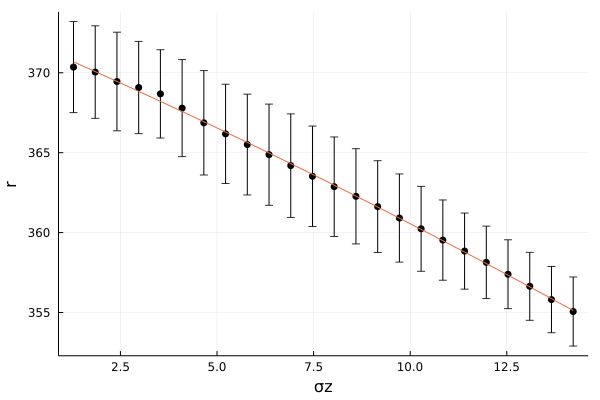

In [27]:
fz2, pz2 = fit_profile(ndfz.zstd1, ndfz.r1, "σz", "r", "pol2")
fpars = fz2.fitpar
fstds = fz2.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f c = %5.2g " fpars[1] fpars[2] fpars[3]
@printf "Fit errors: a = %5.1g b = %5.2g c = %5.2g" fstds[1] fstds[2] fstds[3]
ANema.pout(pz2, joinpath(pathp, "zstd-fitpol2"))
plot(pz2)

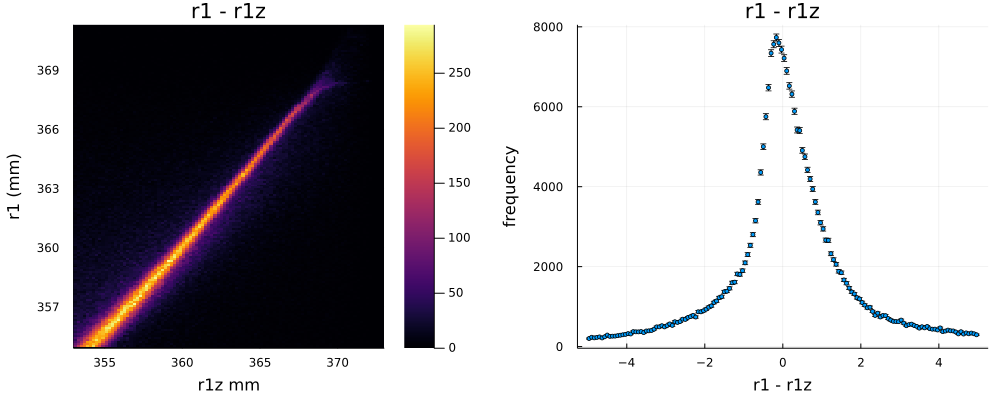

In [28]:
r1z = fz2.g.(ndfz.zstd1) + 0.25 * ones(length(ndfz.q1)) ; 
ANema.plotreso(r1z, ndfz.r1, "r1z mm", "r1 (mm)", -5., 5.0, tit="r1 - r1z", 
         filename=joinpath(pathp, "r1-r1z-zcut"), save=true)


 σ =     0.8 mm

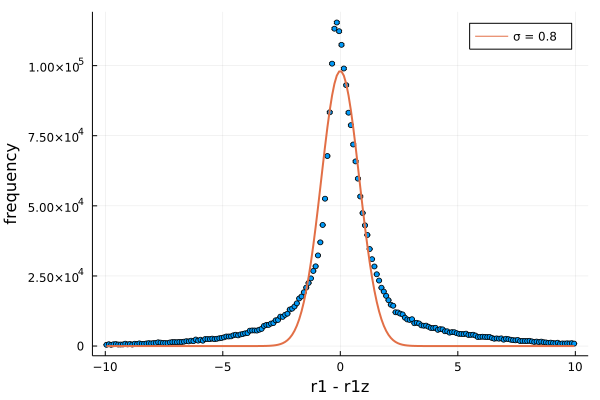

In [29]:
fg,p = fitg1(r1z - ndfz.r1, "r1 - r1z", 200, -10.0, 10.0, xgmin=-5.5, xgmax=5.5)
@printf " σ = %7.1f mm" fg.std[1] 
ANema.pout(p,joinpath(pathp, "zstd-fitg1"))
plot(p)

r-rz σ1 =   2.304 σ2 =   0.526

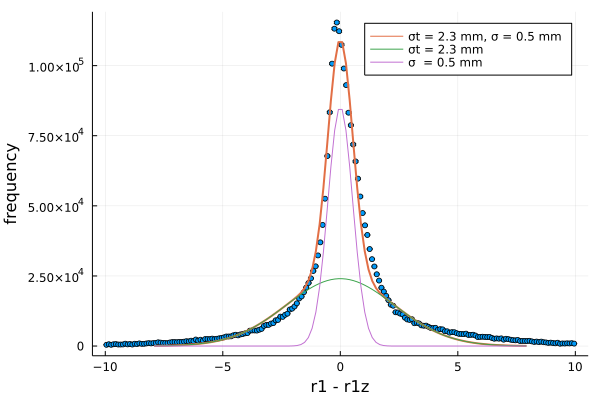

In [30]:
fg, p = fitg2(r1z - ndfz.r1, "r1 - r1z", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-1.5, 
                      xg2min=-1.5,  xg2max =1.5, 
                      xgmin =-8.0, xgmax  =8.0)
@printf "r-rz σ1 = %7.3f σ2 = %7.3f" fg.std[1] fg.std[2]
ANema.pout(p, joinpath(pathp, "zstd-fitg2"))
plot(p)

Fit parameters: a = 372.05 b = -1.05 c = -0.0097 Fit errors: a =   0.1 b = 0.039 c = 0.0024

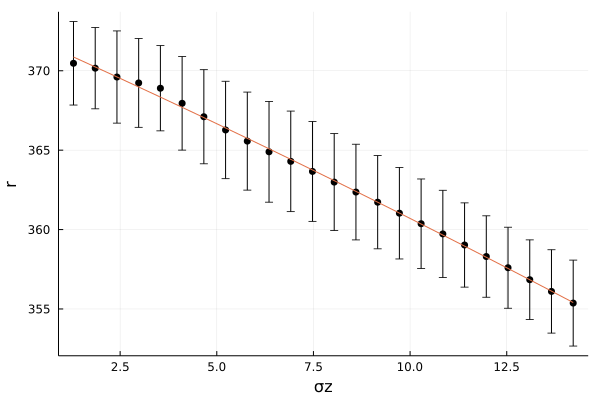

In [31]:
fzr2, pzr2 = fit_profile(ndfz.zstd2, ndfz.r2, "σz", "r", "pol2")
fpars = fz2.fitpar
fstds = fz2.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f c = %5.2g " fpars[1] fpars[2] fpars[3]
@printf "Fit errors: a = %5.1g b = %5.2g c = %5.2g" fstds[1] fstds[2] fstds[3]
ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pzr2)

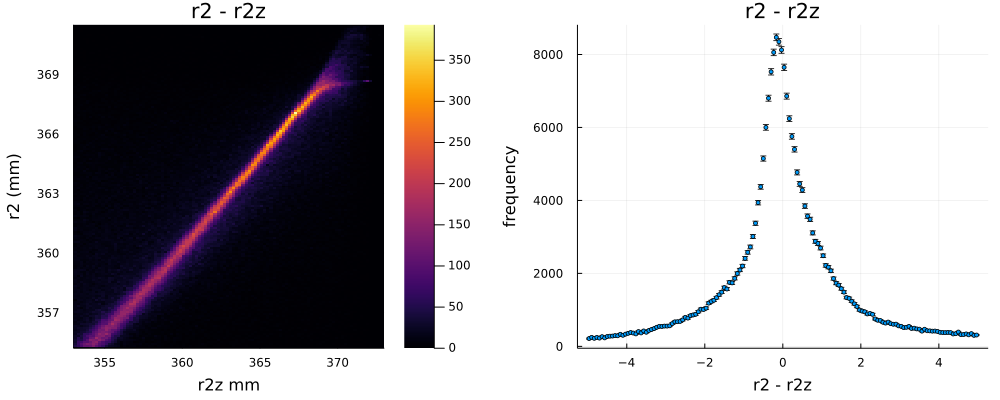

In [38]:
r2z = fzr2.g.(ndfz.zstd2) + 0.25 * ones(length(ndfz.q2)) 
ANema.plotreso(r2z, ndfz.r2, "r2z mm", "r2 (mm)", -5., 5.0, tit="r2 - r2z", 
         filename=filename=joinpath(pathp, "r1-r1z"), save=true)


 σ =     0.8 mm

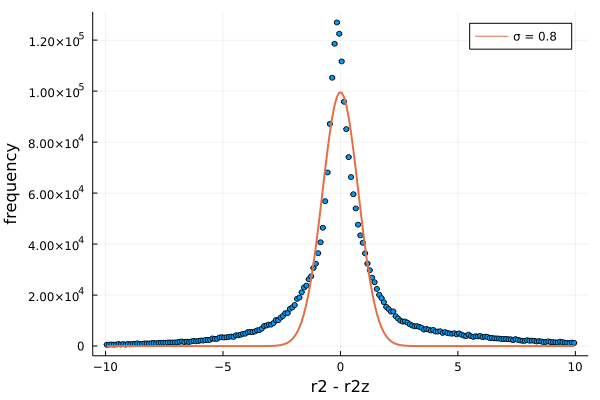

In [39]:
fg,p = fitg1(r2z - ndfz.r2, "r2 - r2z", 200, -10.0, 10.0, xgmin=-2.5, xgmax=2.5)
@printf " σ = %7.1f mm" fg.std[1] 
ANema.pout(p,joinpath(pathp, "zstd-fitg1-r2"))
plot(p)

r-rz σ1 =   2.066 σ2 =   0.445

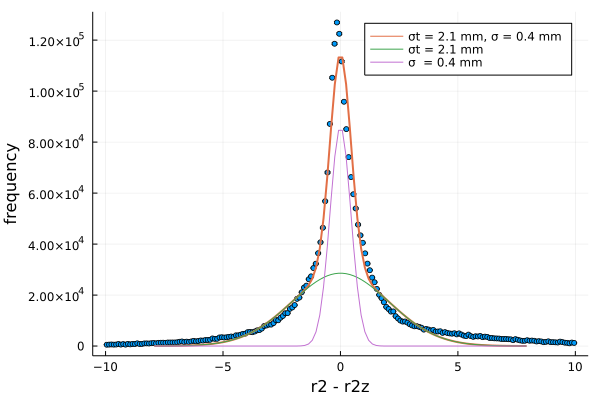

In [40]:
fg, p = fitg2(r2z - ndfz.r2, "r2 - r2z", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-1.5, 
                      xg2min=-1.5,  xg2max =1.5, 
                      xgmin =-8.0, xgmax  =8.0)
@printf "r-rz σ1 = %7.3f σ2 = %7.3f" fg.std[1] fg.std[2]
ANema.pout(p, joinpath(pathp, "zstd-fitg2-r2"))
plot(p)

## Phistd

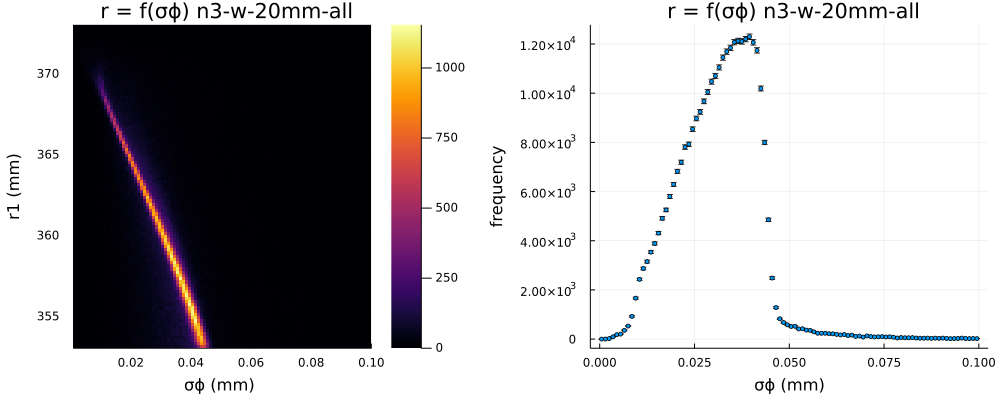

In [41]:
ANema.phistd(ndfq, tit=" r = f(σϕ) $conf", filename=joinpath(pathp, "phistd"), save=true)

In [42]:
ndfp =ANema.selectinterval(ndfq, "phistd1", "phistd2", 0.001, 0.040);
println("after pstd cut: ndfz has a length of ", nrow(ndfp))

after pstd cut: ndfz has a length of 216227


Fit parameters: a = 372.25 b = -412.80 c = 2.1e+02 Fit errors: a =   0.1 b =    11 c = 2.6e+02

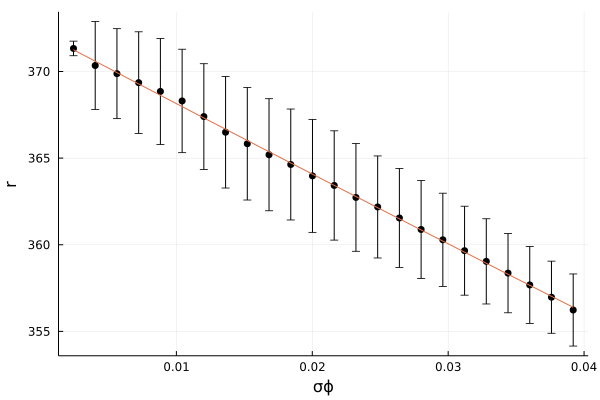

In [43]:
fp2, pp2 = fit_profile(ndfp.phistd1, ndfp.r1, "σϕ", "r", "pol2")
fpars = fp2.fitpar
fstds = fp2.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f c = %5.2g " fpars[1] fpars[2] fpars[3]
@printf "Fit errors: a = %5.1g b = %5.2g c = %5.2g" fstds[1] fstds[2] fstds[3]
ANema.pout(pp2, joinpath(pathp, "phistd-fitpol2"))
plot(pp2)

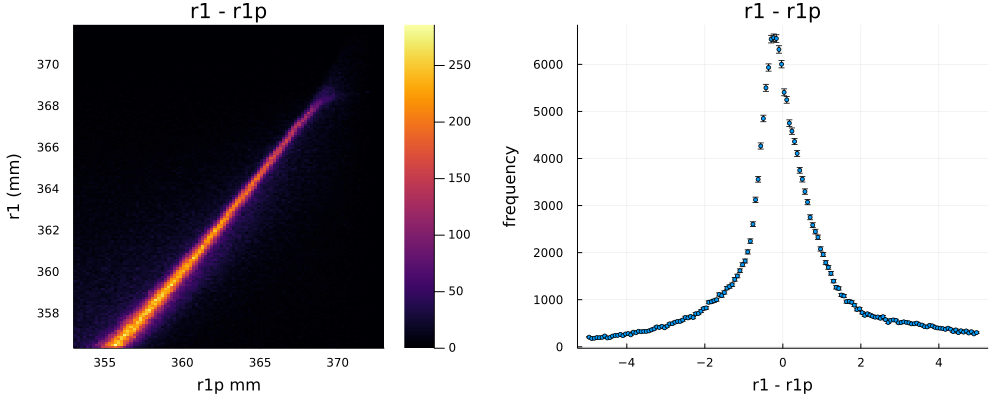

In [44]:
r1p = fp2.g.(ndfp.phistd1) + 0.25 * ones(length(ndfp.q1)) ; 
ANema.plotreso(r1p, ndfp.r1, "r1p mm", "r1 (mm)", -5., 5.0, tit="r1 - r1p", 
         filename=filename=joinpath(pathp, "r1-r1p"), save=true)


r-rz σ1 =   2.792 σ2 =   0.547

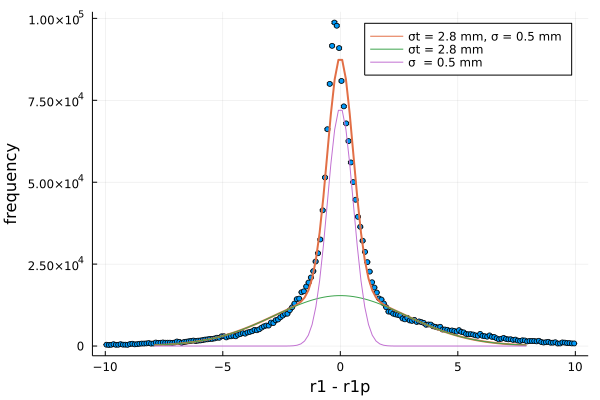

In [45]:
fg, p = fitg2(r1p - ndfp.r1, "r1 - r1p", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-1.5, 
                      xg2min=-1.5,  xg2max =1.5, 
                      xgmin =-8.0, xgmax  =8.0)
@printf "r-rz σ1 = %7.3f σ2 = %7.3f" fg.std[1] fg.std[2]
ANema.pout(p, joinpath(pathp, "phistd-fitg2-r1"))
plot(p)

Fit parameters: a = 372.25 b = -412.80 c = 2.1e+02 Fit errors: a =   0.1 b =    11 c = 2.6e+02

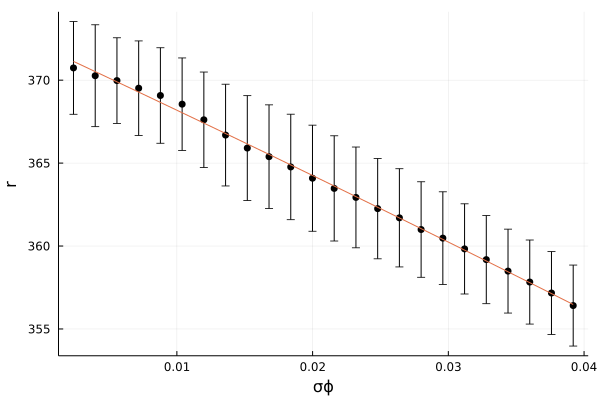

In [46]:
fpr2, ppr2 = fit_profile(ndfp.phistd2, ndfp.r2, "σϕ", "r", "pol2")
fpars = fp2.fitpar
fstds = fp2.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f c = %5.2g " fpars[1] fpars[2] fpars[3]
@printf "Fit errors: a = %5.1g b = %5.2g c = %5.2g" fstds[1] fstds[2] fstds[3]
ANema.pout(ppr2, joinpath(pathp, "phistd-fitpol2-r2"))
plot(ppr2)

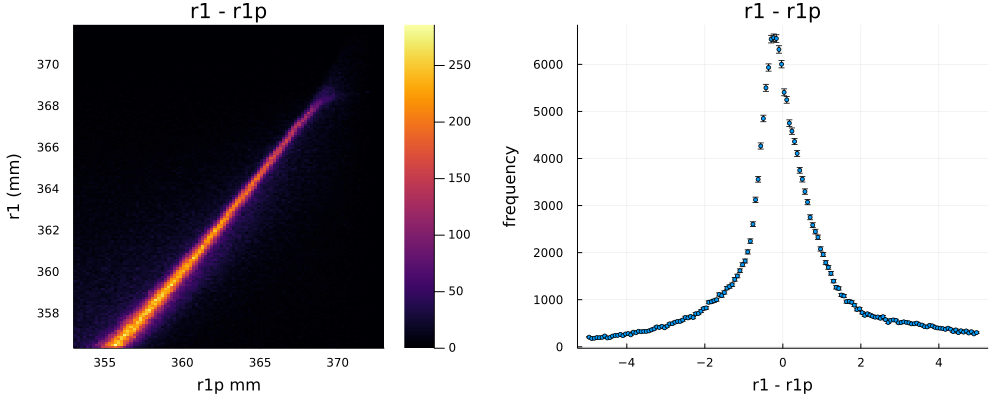

In [47]:
r2p = fpr2.g.(ndfp.phistd2) + 0.25 * ones(length(ndfp.q2)) ; 
ANema.plotreso(r1p, ndfp.r1, "r1p mm", "r1 (mm)", -5., 5.0, tit="r1 - r1p", 
         filename=filename=joinpath(pathp, "r2-r2p"), save=true)


r-rz σ1 =   2.388 σ2 =   0.467

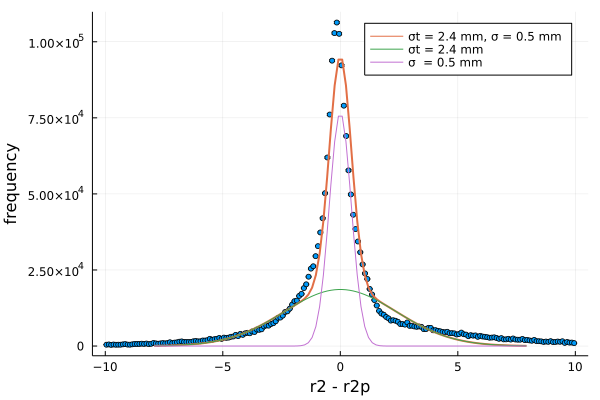

In [48]:
fg, p = fitg2(r2p - ndfp.r2, "r2 - r2p", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-1.5, 
                      xg2min=-1.5,  xg2max =1.5, 
                      xgmin =-8.0, xgmax  =8.0)
@printf "r-rz σ1 = %7.3f σ2 = %7.3f" fg.std[1] fg.std[2]
ANema.pout(p, joinpath(pathp, "phistd-fitg2-r2"))
plot(p)

In [49]:
println("number of  events recorded ", nrow(ndf))
println("number of  events q ϵ (qmin, qmax) ", nrow(ndfq))
println("number of  events zstd ϵ (zstd_min, zstd_max) ", nrow(ndfz))
println("number of  events phistd ϵ (phistd_min, phistd_max) ", nrow(ndfp))

number of  events recorded 1949774
number of  events q ϵ (qmin, qmax) 321299
number of  events zstd ϵ (zstd_min, zstd_max) 266962
number of  events phistd ϵ (phistd_min, phistd_max) 216227


## Resolution in (x,y,z,r) intrinsic

 σx =     0.2 mm σy =     0.2 mm σz =     0.4 mm

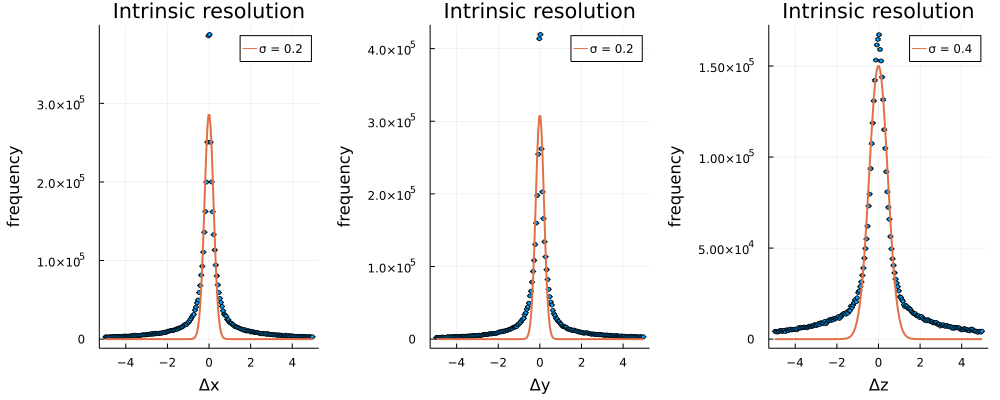

In [50]:
fg,px = fitg1(ndfz.xt1 - ndfz.x1, "Δx", 200, -5.0, 5.0, xgmin=-1.5, xgmax=1.5)
@printf " σx = %7.1f mm" fg.std[1]
fg,py = fitg1(ndfz.yt1 - ndfz.y1, "Δy", 200, -5.0, 5.0, xgmin=-1.5, xgmax=1.5)
@printf " σy = %7.1f mm" fg.std[1]
fg,pz = fitg1(ndfz.zt1 - ndfz.z1, "Δz", 200, -5.0, 5.0, xgmin=-1.5, xgmax=1.5)
@printf " σz = %7.1f mm" fg.std[1]
ANema.plot_and_save(px,py, pz, "Intrinsic resolution", joinpath(pathp, "Intrinsic-res")) 

## Resolución reco

## Position from best estimator (r1p)

In [53]:
xp1,yp1,zp1 = ANema.radial_correction(ndfp.xr1, ndfp.yr1, ndfp.zr1, r1p);
xp2,yp2,zp2 = ANema.radial_correction(ndfp.xr2, ndfp.yr2, ndfp.zr2, r2p);
xz1,yz1,zz1 = ANema.radial_correction(ndfz.xr1, ndfz.yr1, ndfz.zr1, r1z);
xz2,yz2,zz2 = ANema.radial_correction(ndfz.xr2, ndfz.yr2, ndfz.zr2, r2z);

In [54]:
fg,px1 = fitg1(ndfp.xt1 - xp1, "xt-xp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σx1 = %5.2f mm" fg.std[1] 
fg,py1 = fitg1(ndfp.yt1 - yp1, "yt-yp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σy1 = %5.2f mm" fg.std[1] 
fg,pz1 = fitg1(ndfp.zt1 - zp1, "zt-zp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σz = %5.2f mm" fg.std[1] 

 σx1 =  0.58 mm σy1 =  0.61 mm σz =  0.42 mm

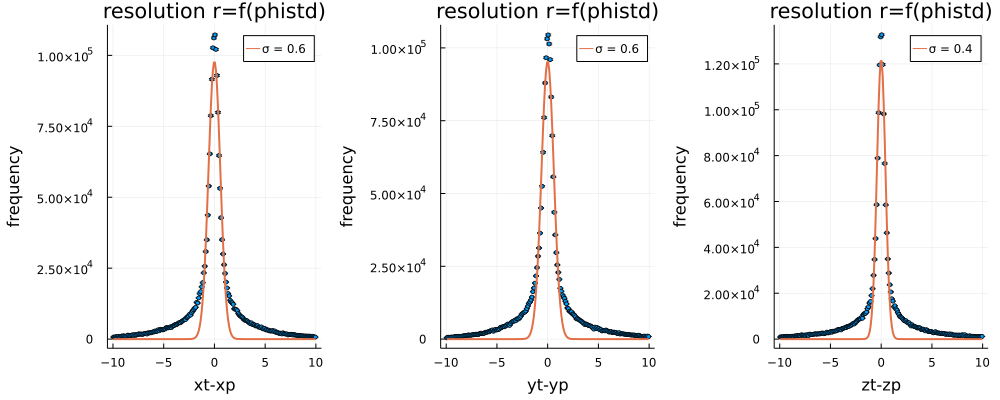

In [55]:
ANema.plot_and_save(px1,py1, pz1, "resolution r=f(phistd)", joinpath(pathp, "phistd-res")) 

x-x(rphi) σ1 =   2.668 σ2 =   0.435y-y(rphi) σ1 =   2.662 σ2 =   0.451z-z(rphi) σ1 =   2.543 σ2 =   0.339

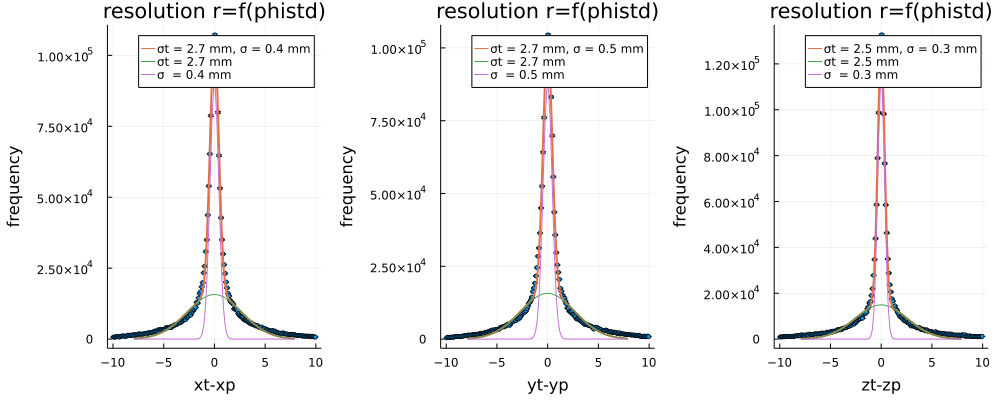

In [56]:
fg, px = fitg2(ndfp.xt1 - xp1, "xt-xp", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-2.5, 
                      xg2min=-2.5,  xg2max =2.5, 
                      xgmin =-8.0, xgmax  =8.0)
@printf "x-x(rphi) σ1 = %7.3f σ2 = %7.3f" fg.std[1] fg.std[2]

fg, py = fitg2(ndfp.yt1 - yp1, "yt-yp", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-2.5, 
                      xg2min=-2.5,  xg2max =2.5, 
                      xgmin =-8.0, xgmax  =8.0)
@printf "y-y(rphi) σ1 = %7.3f σ2 = %7.3f" fg.std[1] fg.std[2]

fg, pz = fitg2(ndfp.zt1 - zp1, "zt-zp", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-2.5, 
                      xg2min=-2.5,  xg2max =2.5, 
                      xgmin =-8.0, xgmax  =8.0)
@printf "z-z(rphi) σ1 = %7.3f σ2 = %7.3f" fg.std[1] fg.std[2]
ANema.plot_and_save(px,py, pz, "resolution r=f(phistd)", joinpath(pathp, "phistd-res-2g"))

 σx1 =  0.53 mm σy1 =  0.54 mm σz =  0.39 mm

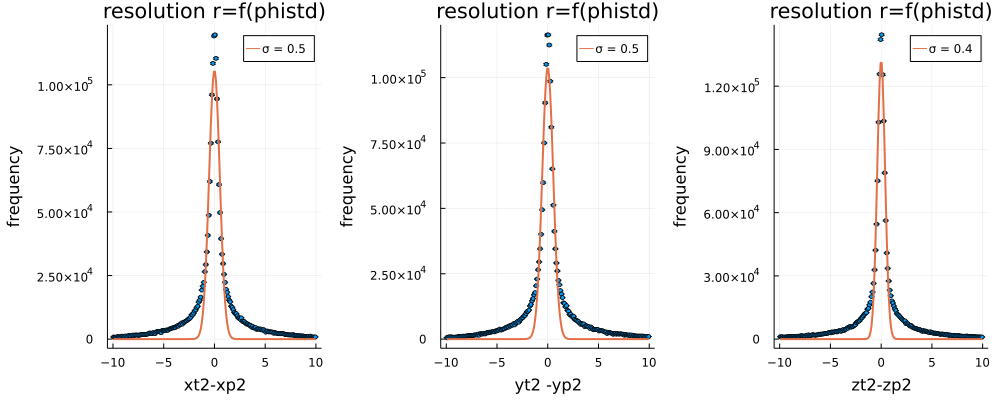

In [57]:
fg,px2 = fitg1(ndfp.xt2 - xp2, "xt2-xp2", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σx1 = %5.2f mm" fg.std[1] 
fg,py2 = fitg1(ndfp.yt2 - yp2, "yt2 -yp2", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σy1 = %5.2f mm" fg.std[1] 
fg,pz2 = fitg1(ndfp.zt2 - zp2, "zt2-zp2", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σz = %5.2f mm" fg.std[1]
ANema.plot_and_save(px2,py2, pz2, "resolution r=f(phistd)", joinpath(pathp, "phistd-res")) 

 σx1 =  0.61 mm σy1 =  0.62 mm σz =  0.45 mm

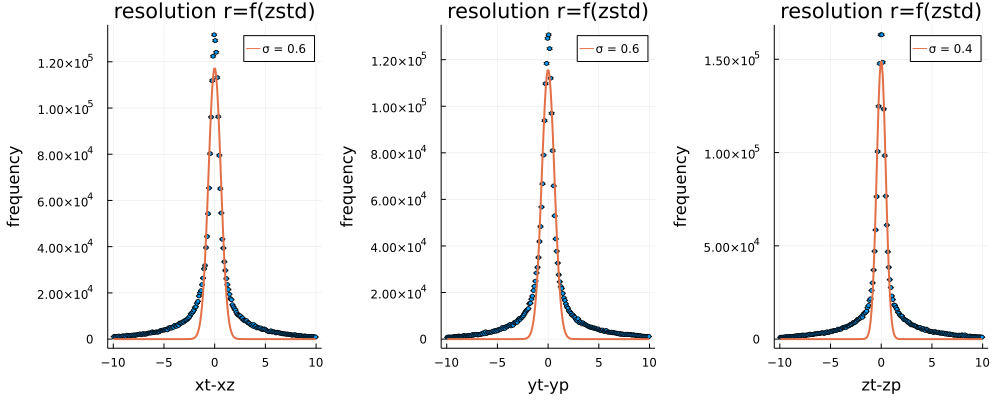

In [58]:
fg,pzx1 = fitg1(ndfz.xt1 - xz1, "xt-xz", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σx1 = %5.2f mm" fg.std[1] 
fg,pzy1 = fitg1(ndfz.yt1 - yz1, "yt-yp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σy1 = %5.2f mm" fg.std[1] 
fg,pzz1 = fitg1(ndfz.zt1 - zz1, "zt-zp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σz = %5.2f mm" fg.std[1]
ANema.plot_and_save(pzx1,pzy1, pzz1, "resolution r=f(zstd)", joinpath(pathp, "zstd-res-r1")) 

 σx1 =  0.56 mm σy1 =  0.57 mm σz =  0.40 mm

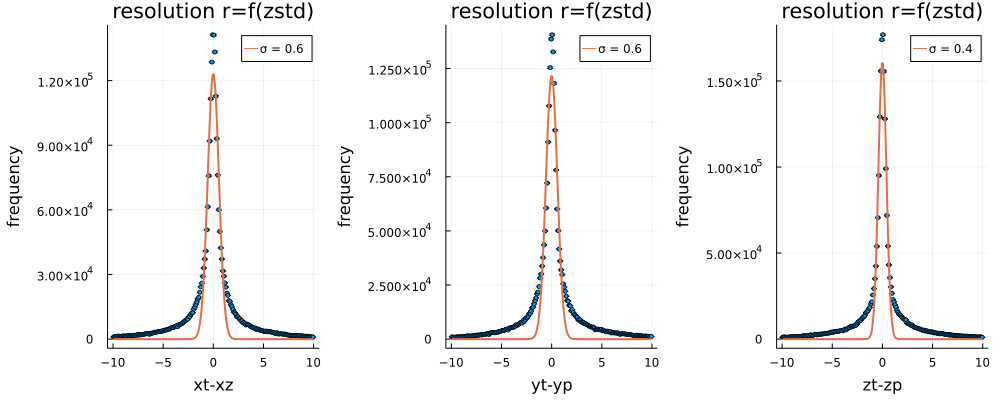

In [59]:
fg,pzx2 = fitg1(ndfz.xt2 - xz2, "xt-xz", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σx1 = %5.2f mm" fg.std[1] 
fg,pzy2 = fitg1(ndfz.yt2 - yz2, "yt-yp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σy1 = %5.2f mm" fg.std[1] 
fg,pzz2 = fitg1(ndfz.zt2 - zz2, "zt-zp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σz = %5.2f mm" fg.std[1]
ANema.plot_and_save(pzx2,pzy2, pzz2, "resolution r=f(zstd)", joinpath(pathp, "zstd-res-r2")) 

## Summary: resolution in (X,Y,Z):
- Resolution in Z is very good, not affected by radial corrections.
- Resolution in (X,Y) depends on r estimator resolution, and is much worse for all events.

In [60]:
@printf "typical resolution (FWHM) = %5.2f" 2.3 * fg.std[1]

typical resolution (FWHM) =  0.92

In [61]:
ndfp[!,"r1x"] = r1p;
ndfp[!,"r2x"] = r2p;
ndfz[!,"r1x"] = r1z;
ndfz[!,"r2x"] = r2z;

## TOF

In [62]:
dfp = ANema.setunits(ndfp);
dfz = ANema.setunits(ndfz);

In [64]:
dt12 = ANema.deltatime(dfp, ANema.dtfirst);

In [65]:
t12 = dt12./ps;

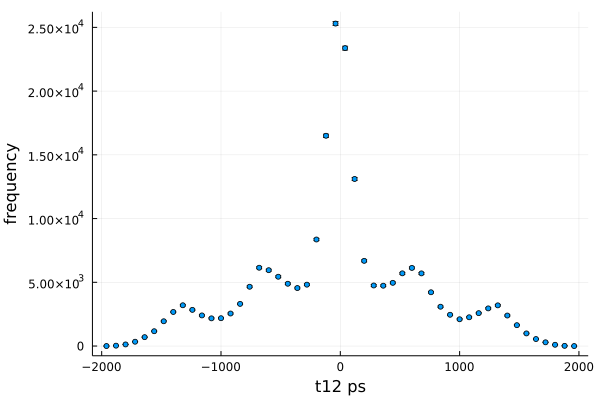

In [66]:
h,p       = hist1d(t12, "t12 ps", 50,  -2000., 2000.)
plot(p)

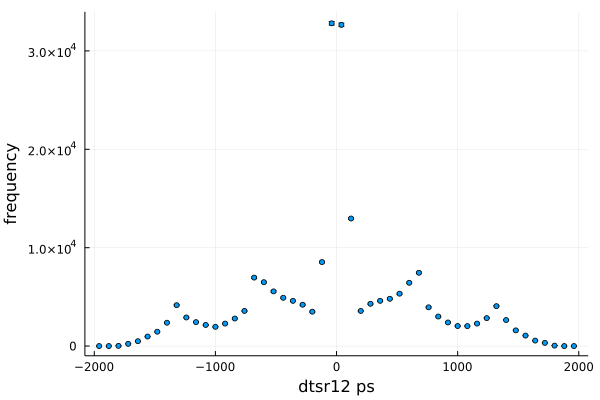

In [68]:
dtsr12 = ANema.ctsr(dfp, ANema.postrue)
tsr12 = dtsr12./ps
h,p       = ANema.hist1d(tsr12, "dtsr12 ps", 50,  -2000., 2000.)
plot(p)

 mean t12 = -20.65 std = 97.29

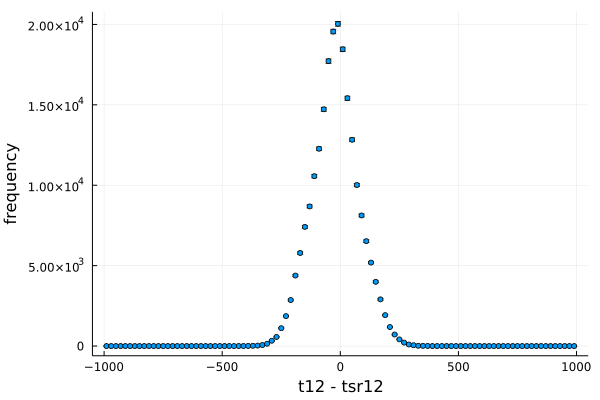

In [69]:
h,p       = hist1d(t12-tsr12, "t12 - tsr12", 100,  -1000., 1000.)
@printf " mean t12 = %5.2f std = %5.2f" mean(t12 - tsr12) std(t12 -tsr12)
plot(p)

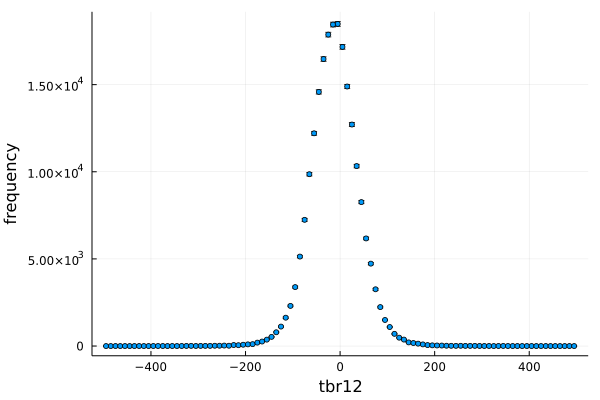

In [71]:
dtrb12 = ANema.cdoi(dfp,  ANema.postrue);
trb12  = dtrb12 ./ps
h,p    = hist1d(trb12, "tbr12", 100,  -500., 500.)
plot(p)

 mean t12 = -8.61 std = 80.44

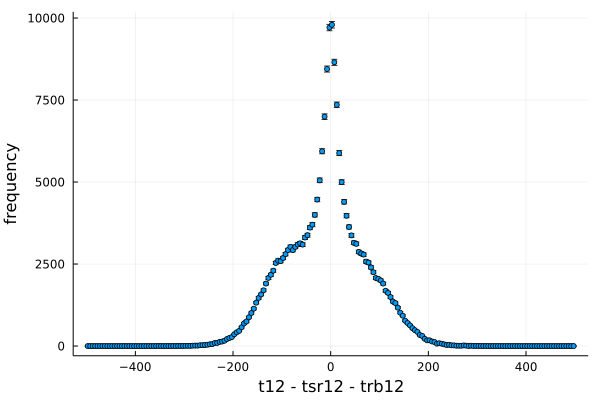

In [72]:
@printf " mean t12 = %5.2f std = %5.2f" mean(t12 - tsr12 - trb12) std(t12 - tsr12 - trb12)
h,p       = hist1d(t12 - tsr12 - trb12  , "t12 - tsr12 - trb12", 200,  -500., 500.)
plot(p)

sigma1 =  93.441 sigma2 =  12.520

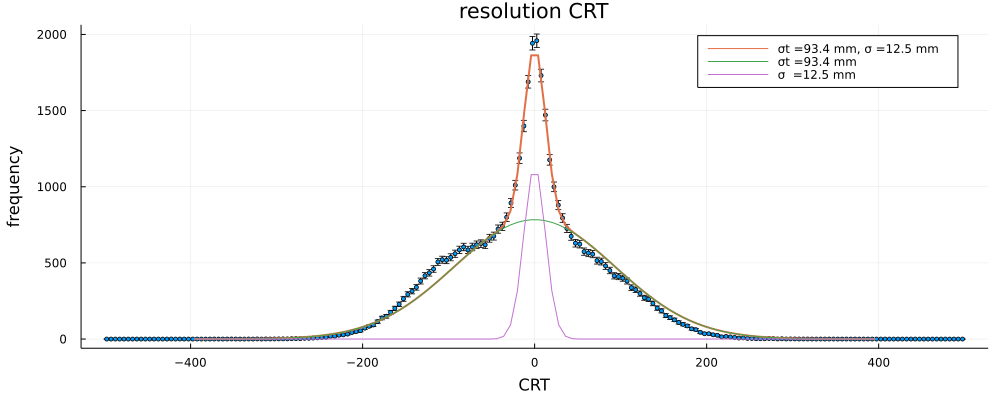

In [73]:
dt = t12 - tsr12 - trb12;
fg, p = fitg2(dt, "CRT", 200, -500.0, 500.0, 
                      xg1min=-400.0, xg1max=-50.0, 
                      xg2min=-50.0,  xg2max =50.0, 
                      xgmin =-400.0, xgmax  =400.0)
@printf "sigma1 = %7.3f sigma2 = %7.3f" fg.std[1] fg.std[2]
ANema.plot_and_save(p, "resolution CRT", joinpath(pathp, "CRT")) 

First photon, position true: FWHM1 = 214.913 FWHM2 =  28.797

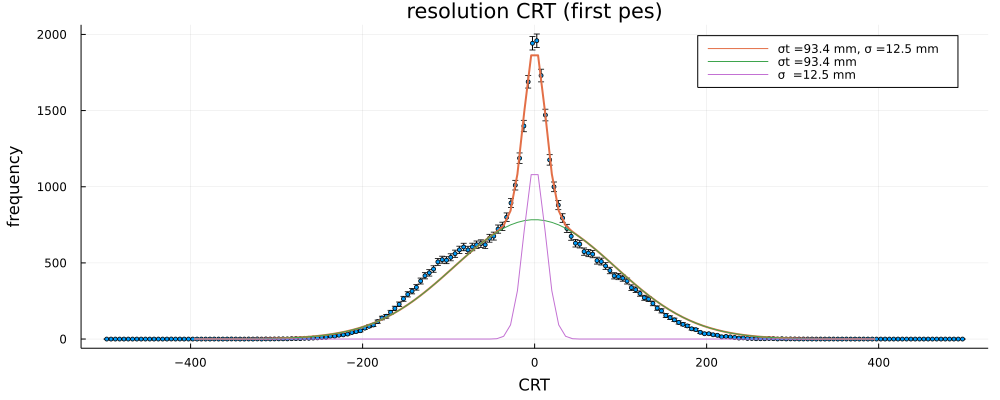

In [74]:
dt = ANema.crt(dfp,  ANema.dtfirst, ANema.postrue)
fg, p = fitg2(dt, "CRT", 200, -500.0, 500.0, 
                      xg1min=-400.0, xg1max=-50.0, 
                      xg2min=-50.0,  xg2max =50.0, 
                      xgmin =-400.0, xgmax  =400.0)
@printf "First photon, position true: FWHM1 = %7.3f FWHM2 = %7.3f" 2.3*fg.std[1] 2.3*fg.std[2]
ANema.plot_and_save(p, "resolution CRT (first pes)", joinpath(pathp, "CRT-first")) 

fastest photoelectron, position reco: FWHM = 224.176

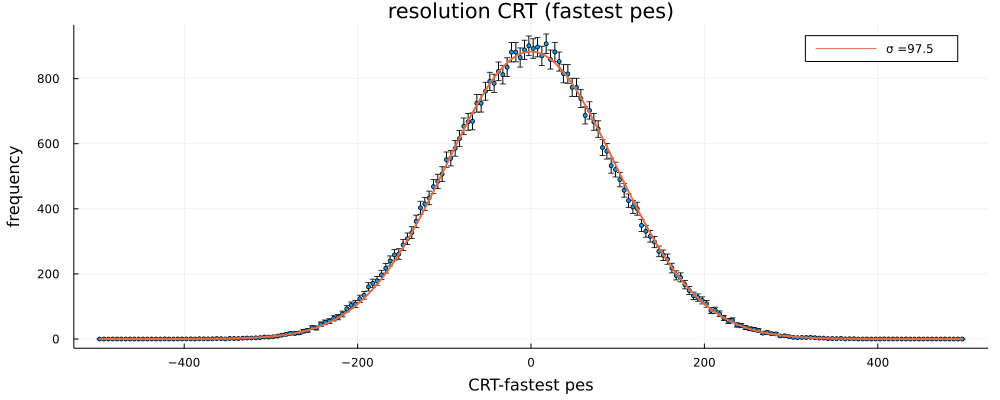

In [75]:
dt = ANema.crt(dfp, ANema.dtminimum, ANema.postrue)
fg,p = fitg1(dt.+10.0, "CRT-fastest pes", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "fastest photoelectron, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
ANema.plot_and_save(p, "resolution CRT (fastest pes)", joinpath(pathp, "CRT-fastest")) 

fastest photoelectron, position reco: FWHM = 231.981

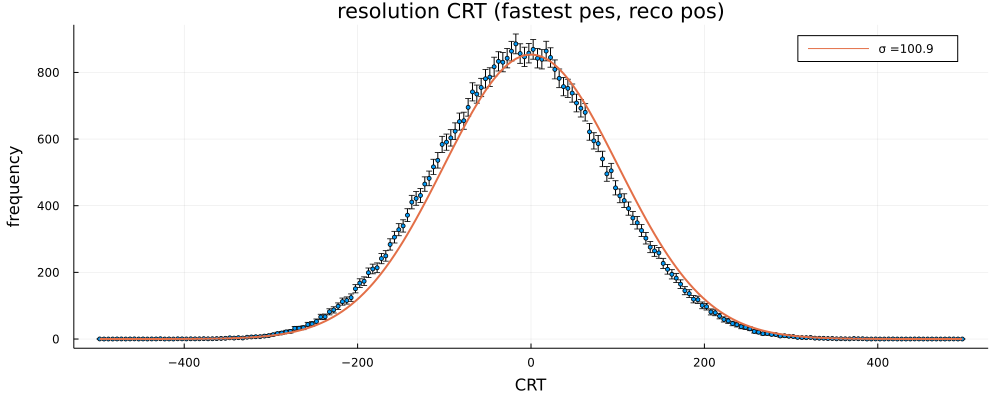

In [76]:
dt = ANema.crt(dfp,  ANema.dtminimum, ANema.posrecall)
fg,p = fitg1(dt, "CRT", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "fastest photoelectron, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
ANema.plot_and_save(p, "resolution CRT (fastest pes, reco pos)", joinpath(pathp, "CRT-fastest-reco")) 

average photoelectrons, position reco: FWHM = 222.847

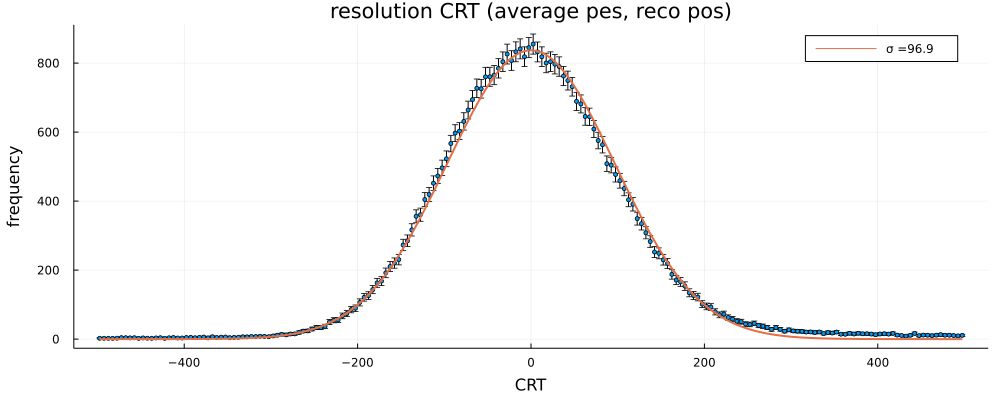

In [77]:
dt = ANema.crt(dfp,  ANema.dtaverage, ANema.posrecall)
fg,p = fitg1(dt, "CRT", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "average photoelectrons, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
ANema.plot_and_save(p, "resolution CRT (average pes, reco pos)", joinpath(pathp, "CRT-average-reco")) 

## Add rx1p and rx2p

In [100]:
ndfp[!,"r1x"] = r1p;
ndfp[!,"r2x"] = r2p;
ndfz[!,"r1x"] = r1z;
ndfz[!,"r2x"] = r2z;

In [101]:
println(names(ndfz))

["nsipm1", "nsipm2", "phistd1", "phistd2", "q1", "q2", "r1", "r2", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zstd1", "zstd2", "zt1", "zt2", "r1x", "r2x"]


In [102]:
println(names(ndfp))

["nsipm1", "nsipm2", "phistd1", "phistd2", "q1", "q2", "r1", "r2", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zstd1", "zstd2", "zt1", "zt2", "r1x", "r2x"]


## Save

In [78]:
ANema.writemdf(patho,"mdf-phistd-$conf.csv", ndfp)
ANema.writemdf(patho,"mdf-zstd-$conf.csv", ndfz)

"../data/n3mf-w-20mm-phot/mdf-zstd-n3-w-20mm-all.csv"